In [ ]:
# Standard library imports
import os
import datetime as dt

# Data handling and numerical computations
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from scipy import interpolate

# PyTorch related imports
import torch
import torch.nn as nn
from torch.distributions import Categorical, Normal, kl_divergence
from torch.profiler import profile, record_function, ProfilerActivity
from torchdiffeq import odeint

# Visualization library
import matplotlib.pyplot as plt

# Utilities and custom modules
from itertools import chain
import lib.utils as utils
import lib.models as models
import lib.train_functions as train_functions
from lib.HHS_data import *
import tqdm

# Setting the number of threads for PyTorch and specifying the device
torch.set_num_threads(1)
# device = 'cpu'  # Uncomment this line if you want to set the device to CPU


In [2]:
root = '../google_queries/'

In [3]:
# MISSING VI and PR

In [22]:
season = 2016
n_qs = 5
n_regions = 10
window = 28
gamma = 56
lag = 14
batch = 0
torch.cuda.reset_peak_memory_stats()
torch.cuda.empty_cache()


ili = load_ili('hhs')
ili = intepolate_ili(ili)

hhs_dict = {}
qs_dict = {}
for i in range(1,1+n_regions):
    hhs_dict[i] = get_hhs_query_data(i, smooth_after = True)
    qs_dict[i] = choose_qs(hhs_dict, ili, i, season, n_qs)

    hhs_dict[i] = hhs_dict[i].loc[:, list(qs_dict[i])]
    hhs_dict[i] = hhs_dict[i].div(hhs_dict[i].max())
    
ili = ili.loc[hhs_dict[i].index[0] : hhs_dict[i].index[-1]]
ili = ili.div(ili.max())

inputs = []
outputs = []

for batch in range(ili.shape[0] - (window+gamma)):
    batch_inputs = []
    for i in range(1,11):
        batch_inputs.append(hhs_dict[i].iloc[batch:batch+window])
    
    t_ili = ili.iloc[batch:batch+window].copy()
    t_ili.iloc[-lag:, :] = -1
    batch_inputs.append(t_ili)
    batch_inputs = np.concatenate(batch_inputs, -1)
    
    batch_outputs = ili.iloc[batch+window-lag:batch+window-lag+gamma].values
    
    inputs.append(batch_inputs)
    outputs.append(batch_outputs)
inputs = torch.tensor(np.asarray(inputs), dtype=torch.float32)
outputs = torch.tensor(np.asarray(outputs), dtype=torch.float32)

/data0/mimorris/torch/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/data0/mimorris/torch/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/data0/mimorris/torch/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/data0/mimorris/torch/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/data0/mimorris/torch/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarni

In [23]:
def reparam(eps, std, mean, n_samples, batch_size):
    z = eps * std + mean
    z = torch.concat([torch.abs(z[..., :2]), (1 - torch.abs(z[..., :2]).sum(-1)).unsqueeze(-1), z[..., 2:]], -1)
    z = z.reshape((n_samples * batch_size, ) + z.shape[2:])
    return z

def make_prior(mean, z_prior=torch.tensor([0.1, 0.01]), device='cpu', latent_dim=8):
    z_prior=z_prior.to(device)
    mean_concat = torch.cat((mean[..., :2]  , torch.zeros_like(mean[..., 2:], device=device)), dim=-1)
    std = torch.cat([z_prior[0].unsqueeze(0), z_prior[1].unsqueeze(0), torch.ones(latent_dim - len(z_prior) - 1, device=device)], 0).expand_as(mean_concat)

    return Normal(mean_concat, torch.abs(std))

In [24]:
class Encoder_BiDirectionalGRU(nn.Module):
    def __init__(self, n_regions, n_qs=10, latent_dim = 6, q_sizes=[128, 64], ili_sizes=[32, 16], ff_sizes = [64,32], SIR_scaler=[0.1, 0.05, 1.0], device='cpu', dtype=torch.float32):
        super(Encoder_BiDirectionalGRU, self).__init__()

        self.scaler = torch.tensor(SIR_scaler, dtype=dtype, device=device)
        self.latent_dim = latent_dim
        if latent_dim > len(self.scaler):
            extension = self.scaler[-1].repeat(latent_dim - len(self.scaler))
            self.scaler = torch.cat([self.scaler, extension])
        self.scaler = self.scaler.view(1, -1)
        
        self.n_regions = n_regions

        self.i_layers = nn.ModuleList()
        self.i_layers.append(nn.GRU(n_regions, ili_sizes[0], batch_first=True))
        for l in range(1, len(ili_sizes)):
            self.i_layers.append(nn.GRU(ili_sizes[l-1], ili_sizes[l], batch_first=True))

        self.q_layers = nn.ModuleList()
        self.q_layers.append(nn.GRU(n_regions * n_qs, q_sizes[0], bidirectional=True, batch_first=True))
        for l in range(1, len(q_sizes)):
            self.q_layers.append(nn.GRU(q_sizes[l-1], q_sizes[l], bidirectional=True, batch_first=True))

        self.ff_layers = nn.ModuleList()
        self.ff_layers.append(nn.Linear(q_sizes[-1]*2 + ili_sizes[-1], ff_sizes[0]))
        for l in range(1, len(ff_sizes)):
            self.ff_layers.append(nn.ReLU())
            self.ff_layers.append(nn.Linear(ff_sizes[l-1], ff_sizes[l]))
        self.ff_layers.append(nn.Linear(ff_sizes[l], 2 * n_regions * latent_dim))

    def forward(self, x):
        x_qs = x[:, :, :-self.n_regions]
        x_ili = x[:, :-14, -self.n_regions:]

        for GRU_layer in self.i_layers:
            x_ili, _ = GRU_layer(x_ili)

        for GRU_layer in self.q_layers:
            x_qs, _ = GRU_layer(x_qs)

        x_concat = torch.cat([x_ili[:, -1, :], x_qs[:, -1, :]], -1)

        for ff_layer in self.ff_layers:
            x_concat = ff_layer(x_concat)

        mean, std = utils.split_last_dim(x_concat)
        mean = mean.reshape(-1, self.n_regions, self.latent_dim)
        std = std.reshape(-1, self.n_regions, self.latent_dim)
        std = torch.abs(std) * self.scaler
        return mean, std


In [39]:
class Encoder_MISO_GRU(nn.Module):
    def __init__(self, n_regions, input_size=10, latent_dim = 6, q_sizes=[128, 64], ili_sizes=[32, 16], ff_sizes = [64,32], SIR_scaler=[0.1, 0.05, 1.0], device='cpu', dtype=torch.float32):
        super(Encoder_MISO_GRU, self).__init__()

        n_qs = input_size-1
        self.scaler = torch.tensor(SIR_scaler, dtype=dtype, device=device)
        self.latent_dim = latent_dim
        if latent_dim > len(self.scaler):
            extension = self.scaler[-1].repeat(latent_dim - len(self.scaler))
            self.scaler = torch.cat([self.scaler, extension])
        self.scaler = self.scaler.view(1, -1)
        
        self.n_regions = n_regions

        self.i_layers = nn.ModuleList()
        self.i_layers.append(nn.GRU(n_regions, ili_sizes[0], batch_first=True))
        for l in range(1, len(ili_sizes)):
            self.i_layers.append(nn.GRU(ili_sizes[l-1], ili_sizes[l], batch_first=True))

        self.q_layers = nn.ModuleList()
        self.q_layers.append(nn.GRU(n_regions * n_qs, q_sizes[0], bidirectional=True, batch_first=True))
        for l in range(1, len(q_sizes)):
            self.q_layers.append(nn.GRU(2*q_sizes[l-1], q_sizes[l], bidirectional=True, batch_first=True))

        self.ff_layers = nn.ModuleList()
        self.ff_layers.append(nn.Linear(q_sizes[-1]*2 + ili_sizes[-1], ff_sizes[0]))
        for l in range(1, len(ff_sizes)):
            self.ff_layers.append(nn.ReLU())
            self.ff_layers.append(nn.Linear(ff_sizes[l-1], ff_sizes[l]))
        self.ff_layers.append(nn.Linear(ff_sizes[l], 2 * n_regions * latent_dim))

    def forward(self, x):
        x_qs = x[:, :, :-self.n_regions]
        x_ili = x[:, :-14, -self.n_regions:]

        for GRU_layer in self.i_layers:
            x_ili, _ = GRU_layer(x_ili)

        for GRU_layer in self.q_layers:
            x_qs, _ = GRU_layer(x_qs)
        x_concat = torch.cat([x_ili[:, -1, :], x_qs[:, -1, :]], -1)

        for ff_layer in self.ff_layers:
            x_concat = ff_layer(x_concat)

        mean, std = utils.split_last_dim(x_concat)
        mean = mean.reshape(-1, self.n_regions, self.latent_dim)
        std = std.reshape(-1, self.n_regions, self.latent_dim)
        std = torch.abs(std) * self.scaler
        return mean, std


In [40]:
n_regions = 10
latent_dim = 6
batch_size = 32
layer_sizes=[50, 50]
n_hidden = 50
cuda = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cuda = torch.device("cpu" if torch.cuda.is_available() else "cpu")
device = 'cpu'

# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

latent_dim=5
# enc = Encoder_BiDirectionalGRU(input_size=6, layer_sizes=layer_sizes, n_hidden=n_hidden, latent_dim=latent_dim-1, n_regions = n_regions, device=device)
enc = Encoder_MISO_GRU(input_size=6, latent_dim=latent_dim-1, n_regions = n_regions, device=device)

ode = models.Fp(n_regions, latent_dim, nhidden=64)
dec = models.Decoder(n_regions, 3, 1, device=device)

enc.to(device)
ode.to(device)
dec.to(device)
print('')

num = np.sum([np.prod(_.shape) for _ in list(enc.parameters())])
print('encoder parameters:', num)

num = np.sum([np.prod(_.shape) for _ in list(ode.parameters())])
print('ode parameters:', num)

num = np.sum([np.prod(_.shape) for _ in list(dec.parameters())])
print('decoder parameters:', num)


encoder parameters: 282512
ode parameters: 8724
decoder parameters: 310


In [41]:
batch_size = 32
new_inputs = torch.tensor(np.asarray(inputs), dtype=torch.float32).to(device)
new_outputs = torch.tensor(np.asarray(outputs), dtype=torch.float32).to(device)

train_size = len(new_inputs) - 365
x_tr, y_tr = new_inputs[:train_size], new_outputs[:train_size]
x_test, y_test = new_inputs[train_size:], new_outputs[train_size:]

# batch it all 
x_train = []
y_train = []
for b in range(int(np.ceil(x_tr.shape[0]/batch_size))):
    x_train.append(torch.tensor(x_tr[b*batch_size:(b+1)*batch_size], dtype=torch.float32))
    y_train.append(torch.tensor(y_tr[b*batch_size:(b+1)*batch_size], dtype=torch.float32))

/tmp/ipykernel_1611925/2700302144.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train.append(torch.tensor(x_tr[b*batch_size:(b+1)*batch_size], dtype=torch.float32))
/tmp/ipykernel_1611925/2700302144.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train.append(torch.tensor(y_tr[b*batch_size:(b+1)*batch_size], dtype=torch.float32))


In [42]:
enc.i_layers[0](x_train[0][..., -10:])
enc.q_layers[0](x_train[0][..., :-10])
enc(x_train[-1])[0].min()

tensor(-0.1984, grad_fn=<MinBackward1>)

In [43]:
lr = 1e-3
means=[0.8, 0.55]
stds = [0.2, 0.2]
optimizer = torch.optim.Adam(chain(enc.parameters(), ode.parameters(), dec.parameters()), lr=lr)
_history = train_functions.history()

In [44]:
optimizer = torch.optim.Adam(enc.parameters(), lr=lr)
for epoch in range(3):
    kls = 0
    pbar = tqdm.tqdm(x_train)
    num = 0
    for x_tr in pbar:
        optimizer.zero_grad()
        
        mean, std = enc(x_tr)
        prior = make_prior(mean, latent_dim=latent_dim, device=device)
        kl = kl_divergence(Normal(mean, std), prior).mean(0).sum()
        if torch.isnan(kl):
            break
        kl.backward()
        optimizer.step()
        kls += kl.cpu().detach().numpy()
        num += 1
        pbar.set_postfix({'Epoch':epoch, 'KL_z':kls/num})

100%|██████████| 177/177 [00:06<00:00, 26.66it/s, Epoch=2, KL_z=0.0109]


In [ ]:
# root = 'checkpoints/HHS_SIR_Big/'      
# enc.load_state_dict(torch.load(root+'enc_' + '.pth'))
# ode.load_state_dict(torch.load(root+'sir_' + '.pth'))
# dec.load_state_dict(torch.load(root+'dec_' + '.pth'))

In [45]:
lr = 1.0e-3
means=[0.8, 0.55]
stds = [0.2, 0.2]
optimizer = torch.optim.Adam(chain(enc.parameters(), ode.parameters(), dec.parameters()), lr=lr)
_history = train_functions.history()

In [53]:
y_tr.shape

torch.Size([32, 56, 10])

In [64]:
y_tr[:, eval_pts, :].shape

torch.Size([32, 9, 10])

In [65]:
dtype=torch.float32
torch.cuda.empty_cache()

n_samples = 128
epochs = 1000
root = 'checkpoints/HHS_SIR_Big/'      
tmax = 9

eval_pts = [0, 6]
while eval_pts[-1] < gamma-1:
    eval_pts.append(eval_pts[-1]+7)
    
for epoch in range(epochs):
    # with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
        t = torch.linspace(0,tmax-1, tmax, device=device)
    
        pbar = tqdm.tqdm(zip(x_train, y_train))
        for x_tr, y_tr in pbar:
            batch_size = x_tr.shape[0]
            eps = torch.randn(n_samples, batch_size, n_regions, latent_dim-1, dtype=dtype, device=device)
            ode.clear_tracking()
            optimizer.zero_grad()
            
            mean, std = enc(x_tr)
            z = reparam(eps, std, mean, n_samples, batch_size)
            latent = odeint(ode, z, t, method='rk4', options=dict(step_size = 1.0))
            y_pred = dec(latent[..., :3]).reshape((-1, n_samples, batch_size, n_regions)).permute(2,1,0,3)
    
            nll = train_functions.nll_loss(y_pred, y_tr[:, eval_pts, :])
            
            kl_p = train_functions.get_kl_params(1, ode.posterior(), means=means, stds = stds,limit = 1e6, device=device)
            kl_z = kl_divergence(make_prior(mean, latent_dim=latent_dim, device=device), Normal(mean, std)).sum(-1).mean() / len(x_train)
            reg_loss = train_functions.latent_init_loss(latent[..., :3])
    
            loss = nll+0.1*kl_p+kl_z+reg_loss
            loss.backward()
            optimizer.step()
            _history.batch([loss.cpu(), nll.cpu(), kl_z.cpu(),kl_p.cpu(),reg_loss.cpu(), optimizer.param_groups[-1]['lr']], ['loss', 'nll', 'kl_latent', 'kl_params', 'reg_loss', 'lr'])
            pbar.set_postfix(_history.epoch())
        _history.reset()
        if epoch > 10:
            if np.all([h['nll'] < -2 for h in _history.epoch_history[-10:]]):
                tmax = min(tmax+1, 5)
            
        utils.update_learning_rate(optimizer, 0.999, lr/10)

        if not os.path.exists(root):
            os.mkdir(root)
        torch.save(enc.state_dict(), root+'enc_' + '.pth')
        torch.save(ode.state_dict(), root+'sir_' + '.pth')
        torch.save(dec.state_dict(), root+'dec_' + '.pth')
    
    # print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))
    # prof.export_chrome_trace(f"trace_epoch_{epoch}.json")
    
    

177it [00:52,  3.36it/s, loss=-.239, nll=-.345, kl_latent=0.00519, kl_params=0.425, reg_loss=0.0586, lr=0.000998]
177it [00:52,  3.35it/s, loss=-.36, nll=-.443, kl_latent=0.00502, kl_params=0.373, reg_loss=0.0408, lr=0.000997] 
177it [00:53,  3.33it/s, loss=-.434, nll=-.5, kl_latent=0.00464, kl_params=0.322, reg_loss=0.0297, lr=0.000996]  
177it [00:52,  3.35it/s, loss=-.534, nll=-.58, kl_latent=0.00439, kl_params=0.265, reg_loss=0.0155, lr=0.000995] 
177it [00:53,  3.33it/s, loss=-.548, nll=-.601, kl_latent=0.00422, kl_params=0.2, reg_loss=0.0286, lr=0.000994]  
177it [00:52,  3.35it/s, loss=-.598, nll=-.635, kl_latent=0.00407, kl_params=0.18, reg_loss=0.014, lr=0.000993]  
177it [00:52,  3.35it/s, loss=-.625, nll=-.658, kl_latent=0.00423, kl_params=0.157, reg_loss=0.0136, lr=0.000992]
177it [00:53,  3.33it/s, loss=-.645, nll=-.674, kl_latent=0.0043, kl_params=0.121, reg_loss=0.0119, lr=0.000991] 
177it [00:52,  3.35it/s, loss=-.605, nll=-.647, kl_latent=0.00549, kl_params=0.118, reg_

KeyboardInterrupt: 

(-2.0, 1.0)

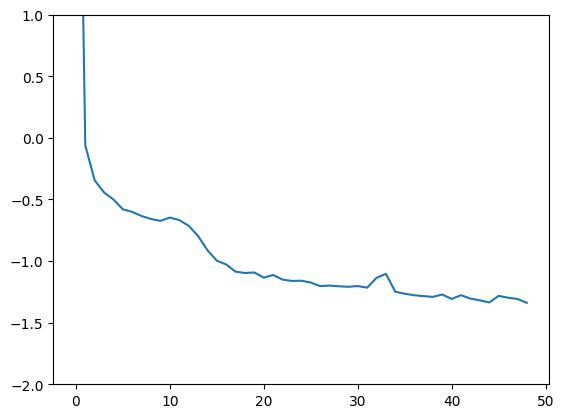

In [66]:
plt.plot([h['nll'] for h in _history.epoch_history])
plt.ylim([-2, 1])

In [67]:
x_in = x_train[-1]
y_in = y_train[-1]

n_samples = 128
dtype=torch.float32
t = torch.linspace(1,4, 28)

batch_size = x_in.shape[0]
eps = torch.randn(n_samples, batch_size, n_regions, latent_dim-1, dtype=dtype, device=device)
ode.clear_tracking()

optimizer.zero_grad()


mean, std = enc(x_in)

z = reparam(eps, std, mean, n_samples, batch_size)
latent = odeint(ode, z, t, method='rk4', options=dict(step_size = 1.0))
y_pred = dec(latent[..., :3]).reshape((gamma, n_samples, batch_size, n_regions)).permute(2,1,0,3)

mean = y_pred.mean(1)
std = y_pred.std(1)

RuntimeError: shape '[56, 128, 13, 10]' is invalid for input of size 465920

In [ ]:
std[..., 0].mean()

In [ ]:
g = 13

for hhs in range(10):

    plt.plot(mean[:, g, hhs].cpu().detach(), color='red')
    plt.plot(y_in[:, g, hhs].cpu().detach())
    
    plt.fill_between(np.linspace(0, mean.shape[0]-1, mean.shape[0]), 
                     (std+mean)[:, g, hhs].cpu().detach(), 
                     (mean-std)[:, g, hhs].cpu().detach(), color='red', alpha=0.3, linewidth=0)
    plt.show()

In [ ]:
x_test.shape